# **CPSC 483: Bitcoin Fraud Detection using Graph Attention Networks**

This is the replication file for the datasets found in my paper "Enhancing Illicit Bitcoin Transaction Detection: Applying Stabilized Self-Training to Graph Attention
Networks". The three types of models and their initializations are shown here as well as the seeds needed to replicate the exact results. For convenience, the GitHub associated with this Jupyter Notebook also includes all seven models that were analyzed in the paper in a `.pth` format for easier PyTorch initialization. Furthermore, `.csv` files of the training/testing processes and their corresponding statistical metrics are also provided.


## 1. Dataset Processing

In this section, the important packages are imported and the dataset is processed for training. I've seen versions of this online where adjacency matrices are made for each time step ([This *Medium* article](https://medium.com/stanford-cs224w-fall-2023-course-projects/illicit-transaction-detection-in-graph-networks-c0d381d85999) doing a similar project does so), but it's actually much faster to create an edge index for each one and then split up the feature matrix and labels into the timesteps afterwards. 

In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import torch_geometric.data as Data
import torch.nn as nn
import torch.nn.functional as F
import copy
import csv
from torch_geometric.nn import GATConv

os.environ['TORCH'] = torch.__version__
print(os.environ['TORCH'])

In [ ]:
%pip install torch-scatter -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
%pip install torch-sparse -f https://data.pyg.org/whl/torch-2.5.1+cu124.html
%pip install torch_geometric

The datasets can be found on the Github page for this project under the 'datasets' folder, but if you'd like a verified dataset, here's the [Kaggle page](https://www.kaggle.com/datasets/ellipticco/elliptic-data-set/data) for the *Elliptic* data set.

In [2]:
edges = pd.read_csv('./datasets/elliptic_bitcoin_dataset/elliptic_txs_edgelist.csv')
features = pd.read_csv('./datasets/elliptic_bitcoin_dataset/elliptic_txs_features.csv', header=None)
classes = pd.read_csv('./datasets/elliptic_bitcoin_dataset/elliptic_txs_classes.csv')

Here, I separate the feature matrix for each timestep. The labels can be separated by the same order. Edges are a little trickier since edges aren't necessarily sorted by timesteps, but we know each 'txId1' node will be in the same timestep as the 'txId2' node since there are no edges across time steps. So, we just iterate through the edge list, check if the ID is in the tx ids for this timestep, and if so, add that edge to the edge_index for this timestep. Then, for each ID, we replace it in the edge_index with its actual index in ts_tx_ids.

In [3]:
timesteps = 49

# List of data for each timestep - timestep 1 is index 0, timstep 2 is index 1, etc.
all_ts_features = []
all_ts_labels = []
all_ts_edges = []

all_ts_tx_ids = []
all_ts_labeled_tx = []
all_ts_unlabeled_tx = []

all_ts_labeled_masks = []
all_ts_unlabeled_masks = []
all_ts_licit_masks = []
all_ts_illicit_masks = []

for ts in range(1, timesteps + 1):
    
    # ---- Extracting features per timestep ----
    features_ts = features[features[1] == ts]
    
    # ---- Extracting labels per timestep ----
    labels_ts = classes[classes['txId'].isin(features_ts[0])]
    tx_ids_ts = list(labels_ts['txId'])
    all_ts_tx_ids.append(tx_ids_ts)
    
    # Extracting transaction labels per timestep and splitting into labeled and unlabeled
    labeled_tx = list(labels_ts[labels_ts['class'] != 'unknown']['txId'])
    unlabeled_tx = list(labels_ts[labels_ts['class'] == 'unknown']['txId'])
    all_ts_labeled_tx.append(labeled_tx)
    all_ts_unlabeled_tx.append(unlabeled_tx)
    
    # making a mask for licit and illicit transactions
    licit_mask = labels_ts['class'] == '2'
    illicit_mask = labels_ts['class'] == '1'
    all_ts_licit_masks.append(torch.tensor(licit_mask.values, dtype=torch.bool))
    all_ts_illicit_masks.append(torch.tensor(illicit_mask.values, dtype=torch.bool))
    
    # Making a mask for labels based on labeled transactions
    labeled_mask = features_ts[0].isin(labeled_tx)
    unlabeled_mask = features_ts[0].isin(unlabeled_tx)
    all_ts_labeled_masks.append(torch.tensor(labeled_mask.values, dtype=torch.bool))
    all_ts_unlabeled_masks.append(torch.tensor(unlabeled_mask.values, dtype=torch.bool))
    
    labels_ts = list(labels_ts['class'])
    # replace unknown with -1, replace 2 with 0. Licit is 0, illicit is 1, unknown is -1
    # Class 0 is LICIT and Class 1 is ILLICIT
    labels_ts = [0 if label == '2' else label for label in labels_ts]
    labels_ts = [-1 if label == 'unknown' else int(label) for label in labels_ts]
    
    
    # ---- Calculating edges for each timestep ----
    # assert tx_ids_ts == list(features_ts[0]), "The order of tx_ids_ts does not match features_ts[0]"
    ts_edges = edges[edges['txId1'].isin(tx_ids_ts)]
    edge_index = torch.tensor(ts_edges.values.T, dtype=torch.long)
    tx_id_to_index = {tx_id: idx for idx, tx_id in enumerate(tx_ids_ts)}
    edge_index = [[tx_id_to_index[tx_id] for tx_id in row] for row in edge_index.numpy()]
    
    
    # Convert to tensor
    features_ts = torch.tensor(features_ts.values[:, 2:], dtype=torch.float)
    labels_ts = torch.tensor(labels_ts, dtype=torch.long)
    edge_index = torch.tensor(edge_index, dtype=torch.long)
    
    all_ts_features.append(features_ts)
    all_ts_labels.append(labels_ts)
    all_ts_edges.append(edge_index)

Here is a sanity check for making sure our graphs are indexed and set up properly. We create a Data object from the corresponding `all_ts_features`, `all_ts_edges`, and `all_ts_labels` The 27th timestep was the smallest one, so it should generate pretty quickly.

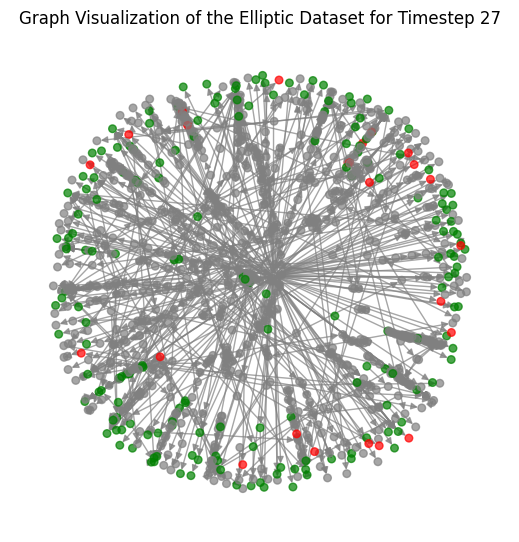

In [24]:
import networkx as nx
import matplotlib.pyplot as plt
from torch_geometric.utils import to_networkx
from torch_geometric.data import Data

data = Data(x=all_ts_features[26], edge_index=all_ts_edges[26], y=all_ts_labels[26])

G = to_networkx(data, to_undirected=False)

label_to_color = {
    -1: 'gray',
    0: 'green',
    1: 'red'
}

labels = data.y.numpy()
node_colors = [label_to_color[labels[node]] for node in G.nodes()]

plt.figure(figsize=(5, 5))
nx.draw(
    G,
    with_labels=False,
    node_color=node_colors,
    edge_color='gray',
    node_size=30,
    alpha=0.7
)
plt.title('Graph Visualization of the Elliptic Dataset for Timestep 27')
plt.show()


Here is a stacked bar graph showing the distribution of illicit, licit, and unknown nodes across time steps.

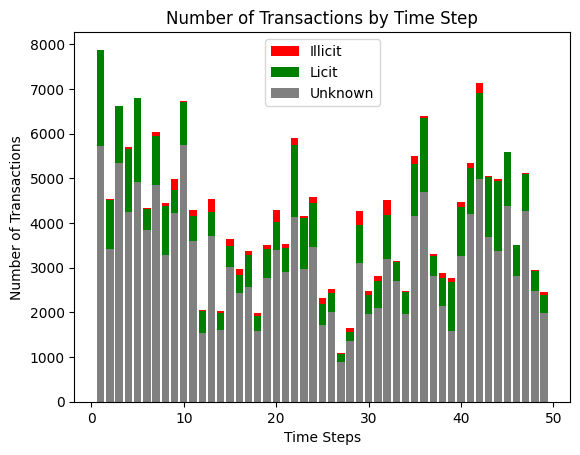

In [30]:
data = all_ts_labels

time_steps = len(data)
unknown_counts = []
licit_counts = []
illicit_counts = []

for ts in data:
    unknown_counts.append((ts == -1).sum().item())  # Count -1s (unknown)
    licit_counts.append((ts == 0).sum().item())    # Count 0s (licit)
    illicit_counts.append((ts == 1).sum().item())  # Count 1s (illicit)

unknown_counts = np.array(unknown_counts)
licit_counts = np.array(licit_counts)
illicit_counts = np.array(illicit_counts)

x = np.arange(1, time_steps+1)

plt.bar(x, illicit_counts, bottom=licit_counts+unknown_counts, color='red', label='Illicit')
plt.bar(x, licit_counts, bottom=unknown_counts, color='green', label='Licit')
plt.bar(x, unknown_counts, color='gray', label='Unknown')

plt.xlabel("Time Steps")
plt.ylabel("Number of Transactions")
plt.title("Number of Transactions by Time Step")
plt.legend()
plt.show()

### Setting up the data splits

We'll be doing an 70:30 training/testing split. The first 34 timesteps will be part of the training, 35 - 49 will be testing.

In [5]:
training_timesteps_start = 1
training_timesteps_end = 34
testing_timesteps_start = 35
testing_timesteps_end = 49

### Stabilized Self-Training

## 2. Setting up the GAT model for training

This is a standard Graph Attention Network model. Typically, you'd add softmax at the end to create probabilities for each class, but the cross-entropy loss does this for us automatically. So, it is commented out here. I added an option for number of heads, hidden channels (node embedding size), and number of layers.

### The Model

In [6]:
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, num_layers, out_channels, dropout=0.6, num_heads=1):
        super(GAT, self).__init__()
        self.in_channels = in_channels
        self.hidden_channels = hidden_channels
        self.num_layers = num_layers
        self.out_channels = out_channels
        self.dropout = dropout
        self.num_heads = num_heads
        
        self.layers = nn.ModuleList()
        
        self.layers.append(GATConv(self.in_channels, self.hidden_channels, heads=self.num_heads, dropout=self.dropout))
        
        for i in range(self.num_layers - 1):
            self.layers.append(GATConv(self.hidden_channels * self.num_heads, self.hidden_channels, heads=self.num_heads, dropout=self.dropout))
        
        self.layers.append(GATConv(self.hidden_channels * self.num_heads, self.out_channels, heads=1, dropout=self.dropout))
        
        
    def forward(self, x, edge_index):
        for l in self.layers[:-1]:
            x = l(x, edge_index)
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.layers[-1](x, edge_index)
        # x = F.log_softmax(x, dim=1)
        return x

### Setting up training and testing functions

In [7]:
def train(data, model, optimizer, loss_fn, labeled_mask=None):
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    
    loss = loss_fn(out[labeled_mask], data.y[labeled_mask]) # change this to add L_ps
    
    loss.backward()
    optimizer.step()
    
    if labeled_mask is not None:
        y_pred = out[labeled_mask].argmax(dim=1)
        y = data.y[labeled_mask]
    else:
        y_pred = out.argmax(dim=1)
        y = data.y
        
    correct = y_pred == y
    acc = correct.sum().float() / y.size(0)
    
    # Calculating precision and recall
    TP = [0, 0]
    FP = [0, 0]
    
    TP[0] = (y_pred[y == 0] == 0).sum().item()
    TP[1] = (y_pred[y == 1] == 1).sum().item()
    FP[0] = (y_pred[y == 1] == 0).sum().item()
    FP[1] = (y_pred[y == 0] == 1).sum().item()
    
    
    return loss.item(), acc.item(), TP, FP

### 3. Training

This is training using a standard loss function for a 1-head GAT, not taking into account pseudolabels. The output graphed on the paper in Figure 3 was created using seeds 42. It does quite well during training with precision and recall both being rather high for illicit classification despite a small dataset.

In [ ]:
num_epochs = 1000
best_model = None
best_valid_acc = 0

seed = 42
file_name = "GAT_1_head_training_" + str(seed)
csv_file = file_name + ".csv"
model_file = file_name + ".pth"
torch.manual_seed(seed)

model = GAT(in_channels=all_ts_features[0].shape[1], hidden_channels=100, num_layers=2, out_channels=2, dropout=0.2, num_heads=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Class 0 is LICIT and Class 1 is ILLICIT
weights = torch.tensor([0.3, 0.7]) # Given 46564 licit and illicit transactions, 9.76% are illicit and 90.24% are licit
loss_fn = nn.CrossEntropyLoss(weight=weights)

with open(csv_file, mode='w', newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Loss", "Accuracy", "Precision 0", "Precision 1", "Recall 0", "Recall 1", "F1 0", "F1 1"])
    
for epoch in range(1, num_epochs+1):
    
    TP = [0, 0]
    FP = [0, 0]
    
    
    for ts in range(training_timesteps_start - 1, training_timesteps_end):
        
        data = Data(x=all_ts_features[ts], edge_index=all_ts_edges[ts], y=all_ts_labels[ts])
        loss, acc, ts_tp, ts_fp = train(data, model, optimizer, loss_fn, labeled_mask=all_ts_labeled_masks[ts])
        TP[0] += ts_tp[0]
        TP[1] += ts_tp[1]
        FP[0] += ts_fp[0]
        FP[1] += ts_fp[1]
        if (acc > best_valid_acc):
            best_valid_acc = acc
            best_model = copy.deepcopy(model)
        
        
    precision_0 = TP[0] / (TP[0] + FP[0]) if TP[0] + FP[0] != 0 else 0
    precision_1 = TP[1] / (TP[1] + FP[1]) if TP[1] + FP[1] != 0 else 0
    
    recall_0 = TP[0] / (TP[0] + FP[1]) if TP[0] + FP[1] != 0 else 0
    recall_1 = TP[1] / (TP[1] + FP[0]) if TP[1] + FP[0] != 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if precision_0 + recall_0 != 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if precision_1 + recall_1 != 0 else 0
    
    print(f"Epoch: {epoch}, loss: {loss}, acc: {acc}, p0: {precision_0}, p1: {precision_1}, r0: {recall_0}, r1: {recall_1}, f1_0: {f1_0}, f1_1: {f1_1}")
    with open(csv_file, mode='a', newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, loss, acc, precision_0, precision_1, recall_0, recall_1, f1_0, f1_1])

torch.save(model.state_dict(), model_file)

This is the training code for the 3-head GAT. The models graphed on Figure 3 of the paper were 3665, 8383, and 98. Precision and recall during training are much higher than the GAT 1H model, but it performed worse during testing, implying a problem of over-fitting.

In [ ]:
num_epochs = 1000
best_model = None
best_valid_acc = 0

seed = 3665
file_name = "GAT_3_head_training_" + str(seed)
csv_file = file_name + ".csv"
model_file = file_name + ".pth"
torch.manual_seed(seed)

model = GAT(in_channels=all_ts_features[0].shape[1], hidden_channels=100, num_layers=2, out_channels=2, dropout=0.2, num_heads=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# Class 0 is LICIT and Class 1 is ILLICIT
weights = torch.tensor([0.3, 0.7]) # Given 46564 licit and illicit transactions, 9.76% are illicit and 90.24% are licit
loss_fn = nn.CrossEntropyLoss(weight=weights)

with open(csv_file, mode='w', newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Loss", "Accuracy", "Precision 0", "Precision 1", "Recall 0", "Recall 1", "F1 0", "F1 1"])
    
for epoch in range(1, num_epochs+1):
    
    TP = [0, 0]
    FP = [0, 0]
    
    
    for ts in range(training_timesteps_start - 1, training_timesteps_end):
        
        data = Data(x=all_ts_features[ts], edge_index=all_ts_edges[ts], y=all_ts_labels[ts])
        loss, acc, ts_tp, ts_fp = train(data, model, optimizer, loss_fn, labeled_mask=all_ts_labeled_masks[ts])
        TP[0] += ts_tp[0]
        TP[1] += ts_tp[1]
        FP[0] += ts_fp[0]
        FP[1] += ts_fp[1]
        if (acc > best_valid_acc):
            best_valid_acc = acc
            best_model = copy.deepcopy(model)
        
    precision_0 = TP[0] / (TP[0] + FP[0]) if TP[0] + FP[0] != 0 else 0
    precision_1 = TP[1] / (TP[1] + FP[1]) if TP[1] + FP[1] != 0 else 0
    
    recall_0 = TP[0] / (TP[0] + FP[1]) if TP[0] + FP[1] != 0 else 0
    recall_1 = TP[1] / (TP[1] + FP[0]) if TP[1] + FP[0] != 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if precision_0 + recall_0 != 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if precision_1 + recall_1 != 0 else 0
    
    print(f"Epoch: {epoch}, loss: {loss}, acc: {acc}, p0: {precision_0}, p1: {precision_1}, r0: {recall_0}, r1: {recall_1}, f1_0: {f1_0}, f1_1: {f1_1}")
    with open(csv_file, mode='a', newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, loss, acc, precision_0, precision_1, recall_0, recall_1, f1_0, f1_1])

torch.save(model.state_dict(), model_file)

### Stabilized Training

This is the pseudo-label loss calculation as described in [Zhou et al](https://arxiv.org/abs/1910.02684). The $L_{sp}$ as defined in the paper is implemented here and is added along to the loss of the actually labeled logits. It is functional but performance does not seem to exceed nor match that of the standard cross-entropy loss.

In [9]:
class PseudoLabelLoss(nn.Module):
    def __init__(self, beta, sp_weight, weight=None):
        super(PseudoLabelLoss, self).__init__()
        self.beta = beta
        self.sp_weight = sp_weight
        self.cross_entropy_loss = nn.CrossEntropyLoss(reduction='mean', weight=weight)
        
    def forward(self, predictions, labels, labeled_mask):
    
        labeled_loss = self.cross_entropy_loss(predictions[labeled_mask], labels[labeled_mask])
        
        probs = F.softmax(predictions, dim=1)
        unlabeled_mask = ~labeled_mask
        unlabeled_probs = probs[unlabeled_mask]
        unlabeled_preds = torch.argmax(unlabeled_probs, dim=1)
        
        conf_unlabeled_mask = torch.max(unlabeled_probs, dim=1).values > self.beta
        if conf_unlabeled_mask.sum() == 0:
            return labeled_loss
        
        conf_probs = unlabeled_probs[conf_unlabeled_mask]
        conf_preds = unlabeled_preds[conf_unlabeled_mask]
        
        weights = torch.ones_like(conf_preds, dtype=torch.float)
        for label in conf_preds.unique():
            label_mask = conf_preds == label
            N_i = label_mask.sum().item() - 1
            weights[label_mask] = 1 / (N_i + 1)
            
        log_probs = torch.log(conf_probs + 1e-10)
        loss_terms = -log_probs[range(len(conf_preds)), conf_preds]
        weighted_loss = torch.sum(weights * loss_terms)
        
        total_loss = labeled_loss + (self.sp_weight * weighted_loss)
        
        # print("Confident Probs:", conf_probs)
        # print("Min Prob:", conf_probs.min().item())
        # print("Total Loss:", total_loss)
        
        return total_loss
        

In [10]:
def train_sst(data, model, optimizer, loss_fn, labeled_mask=None):
    model.train()
    optimizer.zero_grad()
    
    out = model(data.x, data.edge_index)
    
    loss = loss_fn(out, data.y, labeled_mask) # change this to add L_ps
    
    loss.backward()
    optimizer.step()
    
    if labeled_mask is not None:
        y_pred = out[labeled_mask].argmax(dim=1)
        y = data.y[labeled_mask]
    else:
        y_pred = out.argmax(dim=1)
        y = data.y
        
    correct = y_pred == y
    acc = correct.sum().float() / y.size(0)
    
    # Calculating precision and recall
    TP = [0, 0]
    FP = [0, 0]
    
    TP[0] = (y_pred[y == 0] == 0).sum().item()
    TP[1] = (y_pred[y == 1] == 1).sum().item()
    FP[0] = (y_pred[y == 1] == 0).sum().item()
    FP[1] = (y_pred[y == 0] == 1).sum().item()
    
    
    return loss.item(), acc.item(), TP, FP

This is the training cycle for the Stabilized Self-Trained GAT with three heads, with a $\beta$ of 0.9 and a $\lambda_1$ of 0.1. The models in Figure 3 for the GAT 3H + SST was made with seeds 1008, 4092, and 7459. Future experiments could focus on changing these weights to allow more (or less) influence of pseudo-labels on loss.

In [ ]:
num_epochs = 1000
best_model = None
best_acc = 0

seed = 7459
file = "SST_GAT_3H_training_" + str(seed)
csv_file = file + ".csv"
model_file = file + ".pth"
torch.manual_seed(seed)

model = GAT(in_channels=all_ts_features[0].shape[1], hidden_channels=100, num_layers=2, out_channels=2, dropout=0.2, num_heads=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Class 0 is LICIT and Class 1 is ILLICIT
weights = torch.tensor([0.3, 0.7]) # Given 46564 licit and illicit transactions, 9.76% are illicit and 90.24% are licit
loss_fn = PseudoLabelLoss(beta=0.9, sp_weight=0.1, weight=weights)

loss_per_epoch = []

with open(csv_file, mode='w', newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Loss", "Accuracy", "Precision 0", "Precision 1", "Recall 0", "Recall 1", "F1 0", "F1 1"])
    
for epoch in range(1, num_epochs+1):
    
    TP = [0, 0]
    FP = [0, 0]
    
    losses_for_ts = []
    
    for ts in range(training_timesteps_start - 1, training_timesteps_end):
        
        data = Data(x=all_ts_features[ts], edge_index=all_ts_edges[ts], y=all_ts_labels[ts])
        loss, acc, ts_tp, ts_fp = train_sst(data, model, optimizer, loss_fn, labeled_mask=all_ts_labeled_masks[ts])
        TP[0] += ts_tp[0]
        TP[1] += ts_tp[1]
        FP[0] += ts_fp[0]
        FP[1] += ts_fp[1]
        losses_for_ts.append(loss)
        
        
    precision_0 = TP[0] / (TP[0] + FP[0]) if TP[0] + FP[0] != 0 else 0
    precision_1 = TP[1] / (TP[1] + FP[1]) if TP[1] + FP[1] != 0 else 0
    
    recall_0 = TP[0] / (TP[0] + FP[1]) if TP[0] + FP[1] != 0 else 0
    recall_1 = TP[1] / (TP[1] + FP[0]) if TP[1] + FP[0] != 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if precision_0 + recall_0 != 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if precision_1 + recall_1 != 0 else 0
    
    print(f"Epoch: {epoch}, loss: {loss}, acc: {acc}, p0: {precision_0}, p1: {precision_1}, r0: {recall_0}, r1: {recall_1}, f1_0: {f1_0}, f1_1: {f1_1}")
    with open(csv_file, mode='a', newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, loss, acc, precision_0, precision_1, recall_0, recall_1, f1_0, f1_1])
        
    max_loss = max(losses_for_ts)
    loss_per_epoch.append(max_loss)
    if len(loss_per_epoch) > num_epochs // 10:
        popped_loss = loss_per_epoch.pop(0)
        if epoch > num_epochs // 2:
            if min(loss_per_epoch) < max_loss:
                break
    
    if ((acc+precision_0+precision_1+recall_0+recall_1+f1_0+f1_1)/7 > best_acc):
        best_acc = (acc+precision_0+precision_1+recall_0+recall_1+f1_0+f1_1)/7
        best_model = copy.deepcopy(model)
        
torch.save(best_model.state_dict(), model_file)
    

This is the training cycle for the Stabilized Self-Trained GAT with three heads, with a lower $\beta$ of 0.8 and a $\lambda_1$ of 0.2. Here is an example of how one could make a model where the pseudolabels have a greater influence on the training process.

In [ ]:
num_epochs = 1000
best_model = None
best_acc = 0

seed = 1008
file = "SST_GAT_3H_training_" + str(seed)
csv_file = file + ".csv"
model_file = file + ".pth"
torch.manual_seed(seed)

model = GAT(in_channels=all_ts_features[0].shape[1], hidden_channels=100, num_layers=2, out_channels=2, dropout=0.2, num_heads=3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
# Class 0 is LICIT and Class 1 is ILLICIT
weights = torch.tensor([0.3, 0.7]) # Given 46564 licit and illicit transactions, 9.76% are illicit and 90.24% are licit
loss_fn = PseudoLabelLoss(beta=0.8, sp_weight=0.2, weight=weights)

loss_per_epoch = []

with open(csv_file, mode='w', newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Loss", "Accuracy", "Precision 0", "Precision 1", "Recall 0", "Recall 1", "F1 0", "F1 1"])
    
for epoch in range(1, num_epochs+1):
    
    TP = [0, 0]
    FP = [0, 0]
    
    losses_for_ts = []
    
    for ts in range(training_timesteps_start - 1, training_timesteps_end):
        
        data = Data(x=all_ts_features[ts], edge_index=all_ts_edges[ts], y=all_ts_labels[ts])
        loss, acc, ts_tp, ts_fp = train_sst(data, model, optimizer, loss_fn, labeled_mask=all_ts_labeled_masks[ts])
        TP[0] += ts_tp[0]
        TP[1] += ts_tp[1]
        FP[0] += ts_fp[0]
        FP[1] += ts_fp[1]
        losses_for_ts.append(loss)
        
        
    precision_0 = TP[0] / (TP[0] + FP[0]) if TP[0] + FP[0] != 0 else 0
    precision_1 = TP[1] / (TP[1] + FP[1]) if TP[1] + FP[1] != 0 else 0
    
    recall_0 = TP[0] / (TP[0] + FP[1]) if TP[0] + FP[1] != 0 else 0
    recall_1 = TP[1] / (TP[1] + FP[0]) if TP[1] + FP[0] != 0 else 0
    
    f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if precision_0 + recall_0 != 0 else 0
    f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if precision_1 + recall_1 != 0 else 0
    
    print(f"Epoch: {epoch}, loss: {loss}, acc: {acc}, p0: {precision_0}, p1: {precision_1}, r0: {recall_0}, r1: {recall_1}, f1_0: {f1_0}, f1_1: {f1_1}")
    with open(csv_file, mode='a', newline="") as file:
        writer = csv.writer(file)
        writer.writerow([epoch, loss, acc, precision_0, precision_1, recall_0, recall_1, f1_0, f1_1])
        
    max_loss = max(losses_for_ts)
    loss_per_epoch.append(max_loss)
    if len(loss_per_epoch) > num_epochs // 10:
        popped_loss = loss_per_epoch.pop(0)
        if epoch > num_epochs // 2:
            if min(loss_per_epoch) < max_loss:
                break
    
    if ((acc+precision_0+precision_1+recall_0+recall_1+f1_0+f1_1)/7 > best_acc):
        best_acc = (acc+precision_0+precision_1+recall_0+recall_1+f1_0+f1_1)/7
        best_model = copy.deepcopy(model)
        
torch.save(best_model.state_dict(), model_file)

### 4. Testing

Here, we load the models from their respective folders, and test them.

In [ ]:
@torch.no_grad()
def test(model, data, loss_fn, labeled_mask=None):
    model.eval()
    out = model(data.x, data.edge_index)
    
    if labeled_mask is not None:
        loss = loss_fn(out[labeled_mask], data.y[labeled_mask])
        y_pred = out[labeled_mask].argmax(dim=1)
        y = data.y[labeled_mask]
    else:
        loss = loss_fn(out, data.y)
        y_pred = out.argmax(dim=1)
        y = data.y
    
    correct = (y_pred == y).sum().float()
    acc = correct / y.size(0)
    
    TP = [((y == 0) & (y_pred == 0)).sum().item(), ((y == 1) & (y_pred == 1)).sum().item()]
    FP = [((y == 1) & (y_pred == 0)).sum().item(), ((y == 0) & (y_pred == 1)).sum().item()]
        
    return loss.item(), acc.item(), TP, FP

In [ ]:
file = "GAT_1_head_testing_42"
csv_file = file + ".csv"

# Load model
model = GAT(in_channels=all_ts_features[0].shape[1], hidden_channels=100, num_layers=2, out_channels=2, dropout=0.2, num_heads=1)
model.load_state_dict(torch.load("GAT_1_head_42.pth"))

with open(csv_file, mode='w', newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Timestep", "Loss", "Accuracy", "Precision 0", "Precision 1", "Recall 0", "Recall 1", "F1 0", "F1 1", "TP 0", "TP 1", "FP 0", "FP 1"])

for ts in range(testing_timesteps_start - 1, testing_timesteps_end):
  
  TP = [0, 0]
  FP = [0, 0]
  
  data = Data(x=all_ts_features[ts], edge_index=all_ts_edges[ts], y=all_ts_labels[ts])
  loss, acc, tp, fp = test(model, data, loss_fn, labeled_mask=all_ts_labeled_masks[ts])
  TP[0] += tp[0]
  TP[1] += tp[1]
  FP[0] += fp[0]
  FP[1] += fp[1]
  
  precision_0 = TP[0] / (TP[0] + FP[0]) if TP[0] + FP[0] != 0 else 0
  precision_1 = TP[1] / (TP[1] + FP[1]) if TP[1] + FP[1] != 0 else 0
  
  recall_0 = TP[0] / (TP[0] + FP[1]) if TP[0] + FP[1] != 0 else 0
  recall_1 = TP[1] / (TP[1] + FP[0]) if TP[1] + FP[0] != 0 else 0
  
  f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if precision_0 + recall_0 != 0 else 0
  f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if precision_1 + recall_1 != 0 else 0
  
  print(f"Timestep: {ts}, loss: {loss}, acc: {acc}, p0: {precision_0}, p1: {precision_1}, r0: {recall_0}, r1: {recall_1}, f1_0: {f1_0}, f1_1: {f1_1}")
  
  with open(csv_file, mode='a', newline="") as file:
    writer = csv.writer(file)
    writer.writerow([ts, loss, acc, precision_0, precision_1, recall_0, recall_1, f1_0, f1_1, TP[0], TP[1], FP[0], FP[1]])

In [ ]:
file = "GAT_3_head_testing_42"
csv_file = file + ".csv"

# Load model
model = GAT(in_channels=all_ts_features[0].shape[1], hidden_channels=100, num_layers=2, out_channels=2, dropout=0.2, num_heads=3)
model.load_state_dict(torch.load("GAT_3_head_training_98.pth"))

with open(csv_file, mode='w', newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Loss", "Accuracy", "Precision 0", "Precision 1", "Recall 0", "Recall 1", "F1 0", "F1 1", "TP 0", "TP 1", "FP 0", "FP 1"])

for ts in range(testing_timesteps_start - 1, testing_timesteps_end):
  
  TP = [0, 0]
  FP = [0, 0]
  
  data = Data(x=all_ts_features[ts], edge_index=all_ts_edges[ts], y=all_ts_labels[ts])
  loss, acc, tp, fp = test(model, data, loss_fn, labeled_mask=all_ts_labeled_masks[ts])
  TP[0] += tp[0]
  TP[1] += tp[1]
  FP[0] += fp[0]
  FP[1] += fp[1]
  
  precision_0 = TP[0] / (TP[0] + FP[0]) if TP[0] + FP[0] != 0 else 0
  precision_1 = TP[1] / (TP[1] + FP[1]) if TP[1] + FP[1] != 0 else 0
  
  recall_0 = TP[0] / (TP[0] + FP[1]) if TP[0] + FP[1] != 0 else 0
  recall_1 = TP[1] / (TP[1] + FP[0]) if TP[1] + FP[0] != 0 else 0
  
  f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if precision_0 + recall_0 != 0 else 0
  f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if precision_1 + recall_1 != 0 else 0
  
  print(f"Epoch: {ts}, loss: {loss}, acc: {acc}, p0: {precision_0}, p1: {precision_1}, r0: {recall_0}, r1: {recall_1}, f1_0: {f1_0}, f1_1: {f1_1}")
  
  with open(csv_file, mode='a', newline="") as file:
    writer = csv.writer(file)
    writer.writerow([ts, loss, acc, precision_0, precision_1, recall_0, recall_1, f1_0, f1_1, TP[0], TP[1], FP[0], FP[1]])

In [ ]:
seed = 1008
file = "SST_GAT_3_head_testing_" + str(seed)
csv_file = file + ".csv"
model_file = "SST_GAT_3_head_training_" + str(seed) + ".pth"

# Load model
model = GAT(in_channels=all_ts_features[0].shape[1], hidden_channels=100, num_layers=2, out_channels=2, dropout=0.2, num_heads=3)
model.load_state_dict(torch.load(model_file))

with open(csv_file, mode='w', newline="") as file:
    writer = csv.writer(file)
    writer.writerow(["Epoch", "Loss", "Accuracy", "Precision 0", "Precision 1", "Recall 0", "Recall 1", "F1 0", "F1 1", "TP 0", "TP 1", "FP 0", "FP 1"])

for ts in range(testing_timesteps_start - 1, testing_timesteps_end):
  
  TP = [0, 0]
  FP = [0, 0]
  
  data = Data(x=all_ts_features[ts], edge_index=all_ts_edges[ts], y=all_ts_labels[ts])
  loss, acc, tp, fp = test(model, data, loss_fn, labeled_mask=all_ts_labeled_masks[ts])
  TP[0] += tp[0]
  TP[1] += tp[1]
  FP[0] += fp[0]
  FP[1] += fp[1]
  
  precision_0 = TP[0] / (TP[0] + FP[0]) if TP[0] + FP[0] != 0 else 0
  precision_1 = TP[1] / (TP[1] + FP[1]) if TP[1] + FP[1] != 0 else 0
  
  recall_0 = TP[0] / (TP[0] + FP[1]) if TP[0] + FP[1] != 0 else 0
  recall_1 = TP[1] / (TP[1] + FP[0]) if TP[1] + FP[0] != 0 else 0
  
  f1_0 = 2 * precision_0 * recall_0 / (precision_0 + recall_0) if precision_0 + recall_0 != 0 else 0
  f1_1 = 2 * precision_1 * recall_1 / (precision_1 + recall_1) if precision_1 + recall_1 != 0 else 0
  
  print(f"Epoch: {ts}, loss: {loss}, acc: {acc}, p0: {precision_0}, p1: {precision_1}, r0: {recall_0}, r1: {recall_1}, f1_0: {f1_0}, f1_1: {f1_1}")
  
  with open(csv_file, mode='a', newline="") as file:
    writer = csv.writer(file)
    writer.writerow([ts, loss, acc, precision_0, precision_1, recall_0, recall_1, f1_0, f1_1, TP[0], TP[1], FP[0], FP[1]])

Outputs were saved to .csv's and analyzed externally.